### Necessary imports

In [1]:
import torch
import numpy as np
from torch import nn
from time import time
from capsules import *
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn.metrics import accuracy_score

### Definition of CapsNet model

In [2]:
class HitNet4MNIST(nn.Module):
    
    def __init__(self):
        super(HitNet4MNIST, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=256,
                kernel_size=9,
                stride=1
            ),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=256,
                out_channels=256,
                kernel_size=9,
                stride=2
            ),
            nn.ReLU(inplace=True)
        )
        self.hom = HitOrMissLayer()
        self.decoder = RegularizingDecoder([32*10,512,1024,784])
        
    def forward(self, x):
        preprocessed = self.conv(x)
        hom = self.hom(preprocessed)
        internal = 0.5-hom
        lengths = (internal**2).sum(dim=-1)**0.5
        _, max_caps_index = lengths.max(dim=-1)
        masked_internal = mask_hom(hom, max_caps_index.type(torch.FloatTensor))
        reconstructions = self.decoder(
            masked_internal.reshape(masked_internal.shape[0], -1)
        )
        return(internal, lengths, reconstructions)

In [3]:
cn = HitNet4MNIST().cuda()
optimizer = Adam(cn.parameters())
capsule_loss = CentripetalLoss(caps_dimension=32).cuda()

### Data processing

In [4]:
%%bash
git clone https://github.com/sorki/python-mnist.git
cd python-mnist/
./get_data.sh

~/HDD/works/OpenSource/capsules/python-mnist/data ~/HDD/works/OpenSource/capsules/python-mnist
~/HDD/works/OpenSource/capsules/python-mnist


Cloning into 'python-mnist'...
--2019-10-10 12:33:11--  http://yann.lecun.com/exdb/mnist/
Resolving yann.lecun.com (yann.lecun.com)... 216.165.22.6
Connecting to yann.lecun.com (yann.lecun.com)|216.165.22.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29170 (28K) [text/html]
Saving to: ‘data/index.html.tmp’

     0K .......... .......... ........                        100%  221K=0.1s

2019-10-10 12:33:12 (221 KB/s) - ‘data/index.html.tmp’ saved [29170/29170]

Loading robots.txt; please ignore errors.
--2019-10-10 12:33:12--  http://yann.lecun.com/robots.txt
Reusing existing connection to yann.lecun.com:80.
HTTP request sent, awaiting response... 404 Not Found
2019-10-10 12:33:12 ERROR 404: Not Found.

Removing data/index.html.tmp since it should be rejected.

--2019-10-10 12:33:12--  http://yann.lecun.com/
Reusing existing connection to yann.lecun.com:80.
HTTP request sent, awaiting response... 200 OK
Length: 38324 (37K) [text/html]
Saving to: ‘data/index.h

In [5]:
from mnist import MNIST
mndata = MNIST('./python-mnist/data')
images, labels = mndata.load_training()
test_img, test_lab = mndata.load_testing()

In [6]:
images = np.array(images)
labels = np.array(labels)
test_img = np.array(test_img)
test_lab = np.array(test_lab)

In [7]:
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

### Training

In [8]:
n_epochs = 10

In [9]:
training_loss = []
training_accuracy = []
testing_loss = []
testing_accuracy = []
start_time = time()
for epoch in range(n_epochs):
    print("Epoch #"+str(epoch))
    cn.train()
    running_loss = []
    running_accuracy = []
    i = 0
    epoch_time = time()
    for batch_X, batch_y in iterate_minibatches(images, labels, 100):
        if i % 100 == 0:
            print("Minibatch "+str(i)+" of "+str(round(images.shape[0]/100)))
        i += 1
        optimizer.zero_grad()
        inp = torch.from_numpy(
            batch_X.reshape(batch_X.shape[0],1,28,28)/255.0
        ).type(torch.FloatTensor).cuda()
        real_class = make_y(
            torch.from_numpy(batch_y).type(torch.LongTensor).cuda(), 10
        )
        _, lengths, reconstruction = cn(inp)
        loss = capsule_loss(
            lengths, real_class, inp, reconstruction
        )
        loss.backward()
        optimizer.step()
        running_loss.append(loss.cpu().data.numpy())
        running_accuracy.append(
            accuracy_score(lengths.min(1)[1].cpu().data.numpy(), batch_y)
        )
    training_loss.append(np.mean(running_loss))
    training_accuracy.append(np.mean(running_accuracy))
    print("Training loss: "+str(training_loss[-1]))
    print("Training accuracy: "+str(training_accuracy[-1]))
    print("Training in "+str(epoch)+"th epoch took "+str((time() - epoch_time)/60) + " minutes")
    cn.eval()
    running_test_loss = []
    running_test_accuracy = []
    i = 0
    for batch_X, batch_y in iterate_minibatches(test_img, test_lab, 100):
        if i % 100 == 0:
            print("Testing minibatch "+str(i)+" of "+str(round(test_img.shape[0]/100)))
        i += 1
        test_X = torch.from_numpy(
            batch_X.reshape(batch_X.shape[0],1,28,28)/255.0
        ).type(torch.FloatTensor).cuda()
        test_Y = make_y(
            torch.from_numpy(batch_y).type(torch.LongTensor).cuda(), 10
        )
        test_internal, test_lengths, test_reconstruction = cn(test_X)
        running_test_loss.append(
            capsule_loss(
                test_lengths, test_Y, test_X, test_reconstruction
            ).cpu().data.numpy()
        )
        running_test_accuracy.append(
            accuracy_score(test_lengths.min(1)[1].cpu().data.numpy(), batch_y)
        )
    testing_loss.append(np.mean(running_test_loss))
    testing_accuracy.append(np.mean(running_test_accuracy))
    print("Testing loss: "+str(testing_loss[-1]))
    print("Testing accuracy: "+str(testing_accuracy[-1]))
    print(str(epoch)+"th epoch took "+str((time() - epoch_time)/60) + " minutes")
print("All epochs took "+str((time() - start_time)/60) + " minutes")

Epoch #0
Minibatch 0 of 600
Minibatch 100 of 600
Minibatch 200 of 600
Minibatch 300 of 600
Minibatch 400 of 600
Minibatch 500 of 600
Training loss: 0.10137466
Training accuracy: 0.9590333333333333
Training in 0th epoch took 0.5446719328562418 minutes
Testing minibatch 0 of 100
Testing loss: 0.029154724
Testing accuracy: 0.9901000000000001
0th epoch took 0.5658048868179322 minutes
Epoch #1
Minibatch 0 of 600
Minibatch 100 of 600
Minibatch 200 of 600
Minibatch 300 of 600
Minibatch 400 of 600
Minibatch 500 of 600
Training loss: 0.0301739
Training accuracy: 0.9917833333333335
Training in 1th epoch took 0.5260341127713521 minutes
Testing minibatch 0 of 100
Testing loss: 0.017840901
Testing accuracy: 0.992
1th epoch took 0.5466638604799906 minutes
Epoch #2
Minibatch 0 of 600
Minibatch 100 of 600
Minibatch 200 of 600
Minibatch 300 of 600
Minibatch 400 of 600
Minibatch 500 of 600
Training loss: 0.022331133
Training accuracy: 0.9952
Training in 2th epoch took 0.5390448093414306 minutes
Testing 

Text(0.5, 1.0, 'Accuracy')

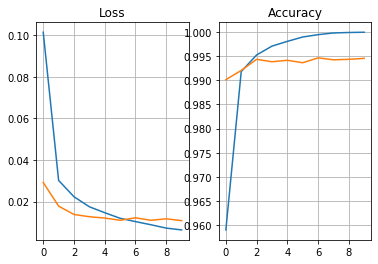

In [19]:
plt.subplot(1,2,1)
plt.plot(training_loss)
plt.plot(testing_loss)
plt.grid(True)
plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(training_accuracy)
plt.plot(testing_accuracy)
plt.grid(True)
plt.title("Accuracy")

In [20]:
torch.save(cn, "mnist_hitnet.ptch")

In [21]:
cn.eval()
random_sample = test_img[np.random.choice(range(test_img.shape[0]), 2)]

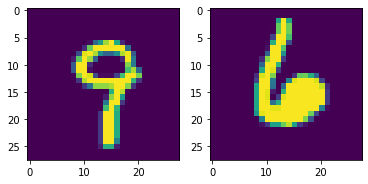

In [22]:
plt.subplot(1,2,1)
plt.imshow(random_sample[0].reshape(28,28))
plt.subplot(1,2,2)
plt.imshow(random_sample[1].reshape(28,28))

In [23]:
_,cl,rec, = cn(Variable(torch.from_numpy(random_sample.reshape(2,1,28,28)/255).type(torch.FloatTensor)).cuda())

In [24]:
cl.shape

torch.Size([2, 10])

In [25]:
rec = rec.cpu().data.numpy()

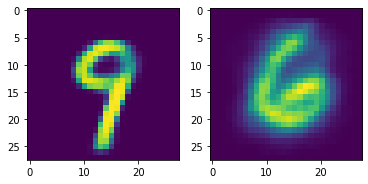

In [26]:
plt.subplot(1,2,1)
plt.imshow(rec[0].reshape(28,28))
plt.subplot(1,2,2)
plt.imshow(rec[1].reshape(28,28))

In [27]:
cl.min(1)

torch.return_types.min(
values=tensor([0.0422, 0.0452], device='cuda:0', grad_fn=<MinBackward0>),
indices=tensor([9, 6], device='cuda:0'))